In [2]:
from itertools import product

import numpy as np
from scipy.linalg import eigvals
from tangelo import SecondQuantizedMolecule
from tangelo.linq import Circuit, Gate, get_backend
from tangelo.toolboxes.ansatz_generator.ansatz_utils import (
    trotterize,
)
from tangelo.toolboxes.operators import QubitOperator, count_qubits
from tangelo.toolboxes.qubit_mappings.mapping_transform import (
    fermion_to_qubit_mapping as f2q_mapping,
)
from tangelo.toolboxes.qubit_mappings.statevector_mapping import (
    do_scbk_transform,
    vector_to_circuit,
)


In [3]:
algorithm_resources = {}

# Set Hamiltonian parameters for LiH simulation in active space.
# diatomic_bond_length = 1.5949
diatomic_bond_length = 1.547
geometry = [("Li", (0.0, 0.0, 0.0)), ("H", (0.0, 0.0, diatomic_bond_length))]
basis = "sto-3g"
multiplicity = 1
active_space_start = 1
active_space_stop = 3

mol_LiH = SecondQuantizedMolecule(
    geometry, symmetry=True
)  # , q=0, spin=0, basis="sto-3g")

## Multi-Reference Selected Quantum Krylov (MRSQK)
The multi-reference selected Quantum Krylov algorithm as outlined in [arXiv:1911.05163](https://arxiv.org/abs/1911.05163) uses multiple reference states and performs multiple time evolutions $U = e^{-iH\tau}$ for time $\tau$, to generate a Krylov representation of the system. The method relies on building two matrices ${\cal{H}}$ and $S$, whose elements are defined by ${\cal{H}_{ia,jb}} = \left<\phi_a\right|U^i H U^j\left|\phi_b\right>$ and $S_{ia,jb} = \left<\phi_a\right|U^i U^j\left|\phi_b\right>$, where $\phi_a, \phi_b$ denote different reference configurations. The matrix elements are measured using the procedure outlined in [arXiv:1911.05163](https://arxiv.org/abs/1911.05163) and the energies obtained through solving ${\cal{H}}V = SVE$.

In [arXiv:2109.06868](https://arxiv.org/abs/2109.06868), it was further noticed that one can use any function of $\cal{H}$ to obtain the eigenvalues. For example, one could use $f({\cal{H}})=e^{-iH\tau}=U$. The same procedure results in the matrix elements $f({\cal{H}})_{ia,jb} = \left<\phi_a\right|U^i U U^j\left|\phi_b\right>, S_{ia,jb} = \left<\phi_a\right|U^i U^j\left|\phi_b\right>$ for the eigenvalue problem $f({\cal{H}})V=SVf(E)$. As $E$ is a diagonal matrix, the correct energies can be obtained by calculating the phase of the eigenvalues ($f(E)=e^{-iE\tau}$) and dividing by $\tau$. (i.e. $\arctan \left[\Im(f(E))/\Re(f(E)) \right]/\tau$). The resulting circuit is slightly longer but much fewer measurements are required. It is worth mentioning that [qubitization](https://arxiv.org/abs/1610.06546), which natively implements $e^{i \arccos(H\tau)}$, can be used without issue. Qubitization is currently one of the most efficient algorithms that implements time-evolution.

In [18]:
class MRSQKSimulator:
    def __init__(self, mol: SecondQuantizedMolecule, mapping="jw"):
        # Number of Krylov vectors
        self.n_krylov = 4

        # Qubit Mapping
        self.mapping = mapping
        # mapping = 'BK'
        # mapping = 'scBK'

        # Molecule
        self.mol = mol
        # mol.fermionic_hamiltonian
        # Qubit operator for LiH
        self.qu_op = f2q_mapping(
            mol.fermionic_hamiltonian,
            mapping,
            mol.n_active_sos,
            mol.n_active_electrons,
            up_then_down=False,
            spin=mol.spin,
        )
        self.backend = get_backend()

        self.c_q = count_qubits(self.qu_op)
        print(f"Qubit count: {self.c_q+1}, control qubit: {self.c_q}")

        self.zeroone = QubitOperator(f"X{self.c_q}", 1) + QubitOperator(
            f"Y{self.c_q}", 1j
        )

        # Generate multiple controlled-reference states.
        self.reference_states: list[Circuit] = list()
        reference_vecs = [[1, 1, 0, 0], [1, 0, 0, 1]]
        for vec in reference_vecs:
            circ = vector_to_circuit(vec)
            gates = [
                Gate("C" + gate.name, target=gate.target, control=self.c_q)
                for gate in circ
            ]
            self.reference_states += [Circuit(gates)]

    def simulate(self, t_end: float) -> np.array:
        # Controlled time-evolution of qu_op
        # print(t_end, int(np.ceil(t_end/0.2)))
        c_trott = trotterize(
            self.qu_op, time=t_end, control=self.c_q,
            # n_trotter_steps=int(np.ceil(t_end/0.2))
            # n_trotter_steps=t_end//0.04
        )  # n_trotter_steps=1, trotter_order=1

        # Calculate MRSQK
        sab = np.zeros((self.n_krylov, self.n_krylov), dtype=complex)
        # hab = np.zeros((self.n_krylov, self.n_krylov), dtype=complex)
        fhab = np.zeros((self.n_krylov, self.n_krylov), dtype=complex)

        for a, b in product(range(self.n_krylov), range(self.n_krylov)):
            # Generate Ua and Ub unitaries
            ua = (
                self.reference_states[a % 2] + c_trott * (a // 2)
                if a > 1
                else self.reference_states[a % 2]
            )
            ub = (
                self.reference_states[b % 2] + c_trott * (b // 2)
                if b > 1
                else self.reference_states[b % 2]
            )

            # Build circuit from Figure 2 for off-diagonal overlap
            hab_circuit = (
                Circuit([Gate("H", self.c_q)])
                + ua
                + Circuit([Gate("X", self.c_q)])
                + ub
            )

            # hab_circuit.remove_small_rotations()
            # hab_circuit.remove_redundant_gates()
            # hab_circuit.simplify()

            sab[a, b] = (
                self.backend.get_expectation_value(self.zeroone, hab_circuit) / 2
            )
            sab[b, a] = sab[a, b].conj()

            # Hamiltonian matrix element for f(H) = e^{-i H \tau}
            fhab[a, b] = (
                self.backend.get_expectation_value(
                    self.zeroone, hab_circuit + c_trott.inverse()
                )
                / 2
            )

            # print(hab_circuit.counts_n_qubit)

            # # Return statevector for faster calculation of Hamiltonian matrix elements
            # _ , initial_state = backend.simulate(hab_circuit, return_statevector=True)
            # for i, (term, coeff) in enumerate(qu_op.terms.items()):

            #     # From calculated statevector append controlled-pauliword for each term in Hamiltonian and measure zeroone
            #     expect = coeff*backend.get_expectation_value(zeroone, c_qu[i], initial_statevector=initial_state) / 2

            #     # Add term to sum
            #     hab[a, b] += expect

        # algorithm_resources["mrsqk"] = dict()
        # algorithm_resources["mrsqk"]["qubit_hamiltonian_terms"] = 0
        # algorithm_resources["mrsqk"]["circuit_2qubit_gates"] = hab_circuit.counts.get("CNOT", 0)
        # algorithm_resources["mrsqk"]["n_post_terms"] = n_krylov**2
        # e, v = scipy.linalg.eigh(hab, sab)
        # print(f"The HV=SVE energies are {np.real_if_close(np.round(e, 3))}")
        e = eigvals(fhab, sab)
        # print(f"The f(H)V=SVf(E) energies are {np.arctan2(np.imag(e), np.real(e))/tau}")
        return np.arctan2(np.imag(e), np.real(e)) / t_end

Qubit count: 11, control qubit: 10


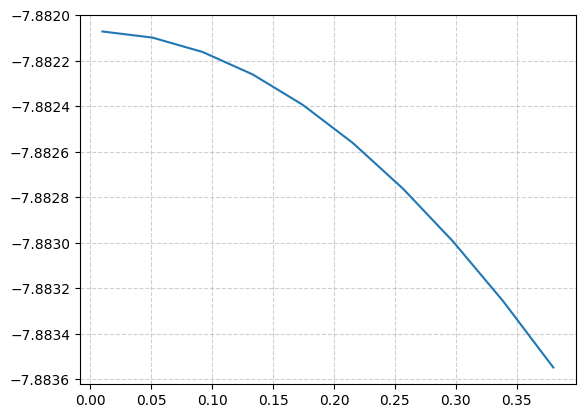

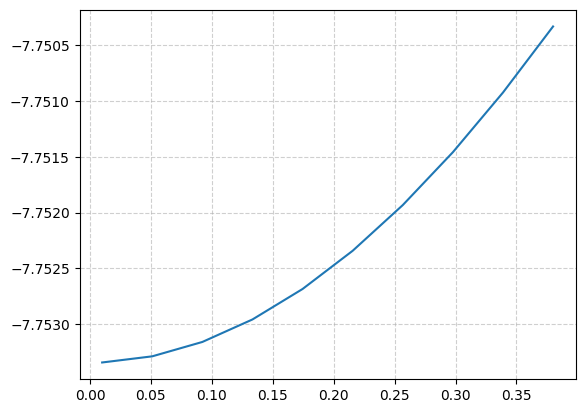

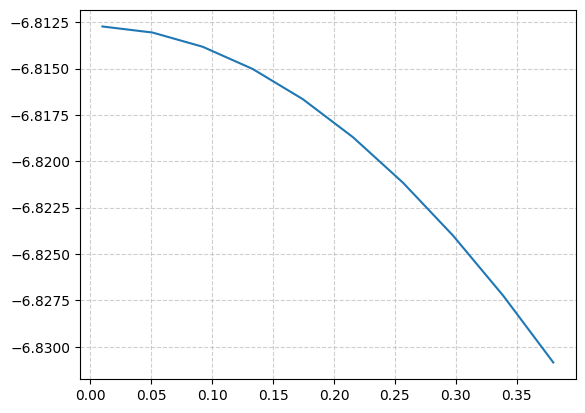

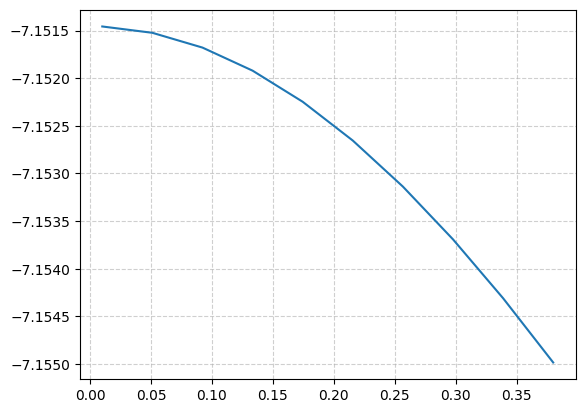

In [5]:
import matplotlib.pyplot as plt

# plot res using the matplotlib library with 4 lines on the same graph over the time np.linspace(0.01, 1.0, 4)
timesteps = np.linspace(0.01, 0.38, 10)
sim = MRSQKSimulator(mol_LiH)
result = np.hstack([np.atleast_2d(sim.simulate(t)).T for t in timesteps])
# result = np.hstack([np.atleast_2d(simulate_molecule(mol_LiH, t)).T for t in timesteps])
# plt.plot(timesteps, *result)
for r in result:
    plt.plot(timesteps, r)
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.show()
# plt.show()

In [148]:
# One rodeo cycle as defined in Fig.1 of arXiv.2110.07747
def rodeo_cycle(hobj, energy, t, i):
    circuit = Circuit([Gate("H", i)])
    circuit += trotterize(hobj, time=t, control=i, trotter_order=2, n_trotter_steps=40)
    circuit += Circuit([Gate("PHASE", i, parameter=energy * t), Gate("H", i)])
    return circuit


def simulate_rodeo(mol):
    h_obj = f2q_mapping(
        mol.fermionic_hamiltonian,
        "scbk",
        mol.n_active_sos,
        mol.n_active_electrons,
        up_then_down=True,
        spin=mol.spin,
    )

    n_qubits = count_qubits(h_obj)
    print(f"Qubit count: {n_qubits}")

    # Stretch factor of 300 to make eigenvalue gap larger. Therefore, time evolution needs to be shorter.
    # h_obj = 300*(h_obj - QubitOperator((), -14.85))
    h_obj = 300 * (h_obj - QubitOperator((), -7.88))

    sim = get_backend()

    sigma = 0.4

    # We will use multiple reference states as probability depends on overlap with starting state.
    ref_states = [
        vector_to_circuit(do_scbk_transform([1, 1, 0, 0], 4)),
        vector_to_circuit(do_scbk_transform([1, 0, 1, 0], 4)),
        vector_to_circuit(do_scbk_transform([0, 0, 1, 1], 4)),
    ]

    # Equivalent to energies from -14.9 -> 14.75 for 10 iterations.
    energies = [-0.05 * 300 + 300 * 0.005 * i for i in range(30)]
    success_prob = list()
    for energy in energies:
        success = 0
        for sample in range(10):
            t = np.random.normal(0, sigma, 1)
            circuit = np.random.choice(ref_states)
            for i, tk in enumerate(t):
                circuit += rodeo_cycle(h_obj, energy, tk, i + n_qubits)
            f, _ = sim.simulate(circuit)
            for key, v in f.items():
                if key[2:] == "0":
                    success += v
        success_prob.append(success / 10)

    algorithm_resources["rodeo"] = dict()
    algorithm_resources["rodeo"]["qubit_hamiltonian_terms"] = 0
    algorithm_resources["rodeo"]["circuit_2qubit_gates"] = circuit.counts.get("CNOT", 0)
    algorithm_resources["rodeo"]["n_post_terms"] = 30

    return energies, success_prob

In [149]:
# Rodeo algorithm too expensive here.
# energies, success_prob = simulate_rodeo(mol_LiH)

Qubit count: 8


Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x1075a48c0>>
Traceback (most recent call last):
  File "/Users/rohan/.pyenv/versions/3.12.5/envs/nyc_haq/lib/python3.12/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(

KeyboardInterrupt: 


Qubit count: 11, control qubit: 10


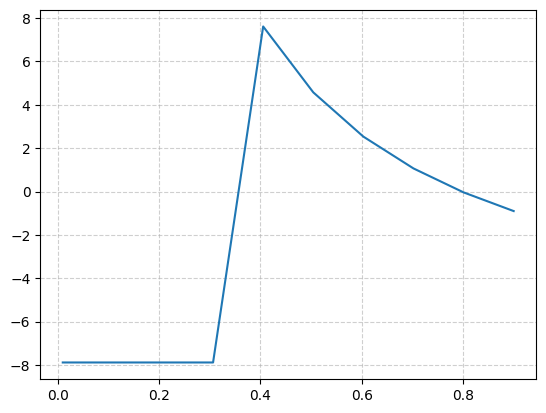

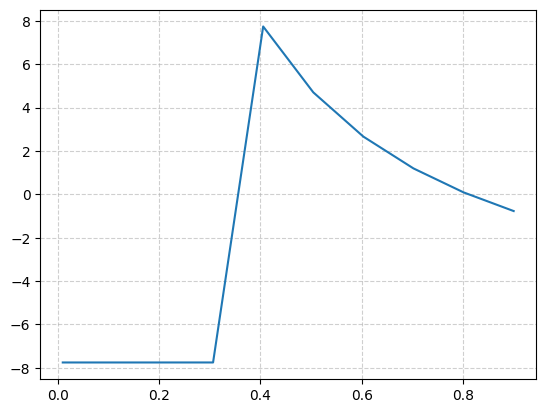

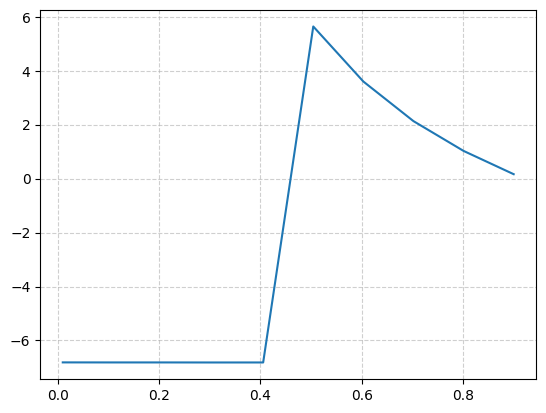

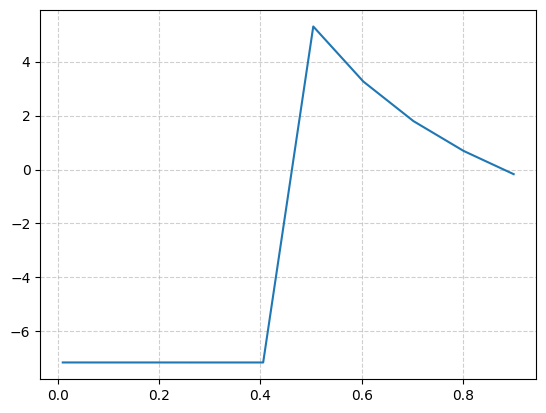

In [19]:
timesteps = np.linspace(0.01, 0.9, 10)
sim = MRSQKSimulator(mol_LiH)
result = np.hstack([np.atleast_2d(sim.simulate(t)).T for t in timesteps])
# result = np.hstack([np.atleast_2d(simulate_molecule(mol_LiH, t)).T for t in timesteps])
# plt.plot(timesteps, *result)

for r in result:
    plt.plot(timesteps, r)
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.show()
# plt.show()